In [2]:
from google.colab import drive
drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive/parking_spots_detector/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import numpy as np
import os, glob, pickle, cv2
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline


from tensorflow.keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

## Imports for making predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.models import load_model
from keras.preprocessing import image

In [24]:
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(15, 12))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

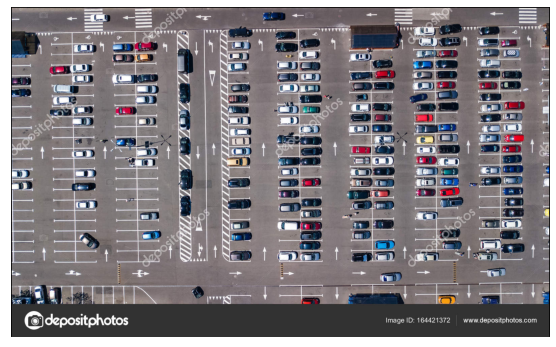

In [25]:
test_images = [plt.imread(path) for path in glob.glob(drive_path + 'real_image/*.jpg')]

show_images(test_images)

---
## Training the model

In [26]:
train_data_dir = drive_path + 'train_data/train'
validation_data_dir = drive_path + 'train_data/test'

files_train = 0
files_validation = 0


for sub_folder in os.listdir(train_data_dir):
    path, dirs, files = next(os.walk(os.path.join(train_data_dir, sub_folder)))
    files_train += len(files)


for sub_folder in os.listdir(validation_data_dir):
    path, dirs, files = next(os.walk(os.path.join(validation_data_dir, sub_folder)))
    files_validation += len(files)

print(files_train,files_validation)

381 164


Set Key Parameters

In [27]:
img_width, img_height = 48, 48
train_samples = files_train
validation_samples = files_validation
batch_size = 32
epochs = 15
num_classes = 2

Building a model on a VGG

In [28]:
model = applications.VGG16(weights = 'imagenet', include_top=False, input_shape = (img_width, img_height, 3))

# Freezing the first 5 layers
for layer in model.layers[:10]:
    layer.trainable = False
    
x = model.output
x = Flatten()(x)
predictions = Dense(num_classes, activation='softmax')(x)

# creating the final model
model_final = Model(inputs = model.input, outputs = predictions)
model_final.compile(loss = 'categorical_crossentropy', 
                    optimizer = SGD(learning_rate=0.0001, momentum=0.9), 
                    metrics=['accuracy'])

Instantiate train and test generators with data augmentation

In [29]:
train_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True, fill_mode = 'nearest', 
                                   zoom_range = 0.1, width_shift_range = 0.1, height_shift_range=0.1, 
                                   rotation_range=5)

test_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True, fill_mode = 'nearest', 
                                  zoom_range = 0.1,width_shift_range = 0.1, height_shift_range=0.1, 
                                  rotation_range=5)

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size = (img_height, img_width), 
                                                    batch_size = batch_size, class_mode = 'categorical')

validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size = (img_height, img_width), 
                                                        class_mode = 'categorical')

Found 381 images belonging to 2 classes.
Found 164 images belonging to 2 classes.


Train the model

In [30]:
# Setting Conditions
checkpoint = ModelCheckpoint('car_identifier.h5', monitor='accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto', 
                             save_freq=1)
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

# Training
history_object = model_final.fit(
train_generator,
steps_per_epoch = train_samples//batch_size,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_samples,
callbacks = [checkpoint, early])

Epoch 1/15

Epoch 1: accuracy improved from -inf to 0.18750, saving model to car_identifier.h5
 1/11 [=>............................] - ETA: 9s - loss: 1.1089 - accuracy: 0.1875
Epoch 1: accuracy improved from 0.18750 to 0.21875, saving model to car_identifier.h5
 2/11 [====>.........................] - ETA: 3s - loss: 1.0174 - accuracy: 0.2188
Epoch 1: accuracy improved from 0.21875 to 0.32292, saving model to car_identifier.h5
 3/11 [=======>......................] - ETA: 2s - loss: 0.9280 - accuracy: 0.3229
Epoch 1: accuracy improved from 0.32292 to 0.35156, saving model to car_identifier.h5
 4/11 [=========>....................] - ETA: 2s - loss: 0.9058 - accuracy: 0.3516
Epoch 1: accuracy improved from 0.35156 to 0.39375, saving model to car_identifier.h5
 5/11 [============>.................] - ETA: 2s - loss: 0.8670 - accuracy: 0.3938
Epoch 1: accuracy improved from 0.39375 to 0.42188, saving model to car_identifier.h5
 6/11 [===============>..............] - ETA: 1s - loss: 0.8

Save the model

In [31]:
model_final.save('car_identifier.h5') 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


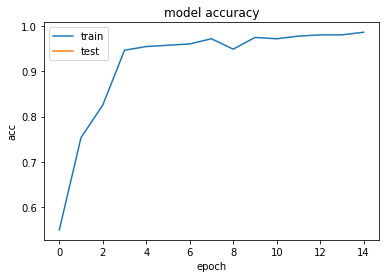

In [32]:
print(history_object.history.keys())
plt.plot(history_object.history['accuracy'])
plt.plot(history_object.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

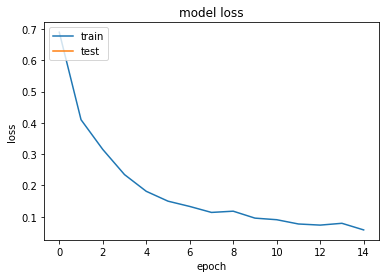

In [33]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

---

## Set up Parking Slots

In [34]:
try:
    with open('positions', 'rb') as f:
        list_positions = pickle.load(f)
except:
    list_positions = list()

In [35]:
# an approximate area of a single slot
width, height  = 60, 25

def mouse_click(click, x, y):
    '''
    The function helps picking parking 
    slot from an image.
    
    Args:
        click: the clicked mouse button
        x: 
        y:
    Returns:
        the co-ordinates of parking slots
        generated.
    '''
    if click == cv2.EVENT_LBUTTONDOWN:
        list_positions.append((x, y))
    elif click == cv2.EVENT_RBUTTONDOWN:
        for i, position in enumerate(list_positions):
            x1, y1 = position
            if x1 < x < x1 + width and y1 < y < y1 + height:
                list_positions.pop(i)

    with open('positions', 'wb') as f:
        pickle.dump(list_positions, f)

**The cell below is commented out. It can be used to modify the slot positions**

In [36]:
# list_positions = [] 
# while True:
#     image = cv2.imread('real_image/parking_lot.jpg')
#     for position in list_positions:
#         cv2.rectangle(image, position, (position[0]+width, position[1]+height), (255,0,255), 1)
#     cv2.namedWindow("image", cv2.WINDOW_NORMAL)
#     cv2.imshow('image', image)
#     cv2.setMouseCallback('image', mouse_click)
#     cv2.waitKey(1)

In [37]:
with open(drive_path+'positions', 'rb') as f:
    list_positions = pickle.load(f)
    
my_spots = {}
for i, pos in enumerate(list_positions):
    my_spots[i] = pos[0],pos[1],pos[0]+width, pos[1]+height
    
my_spots = {v: k for k, v in my_spots.items()}

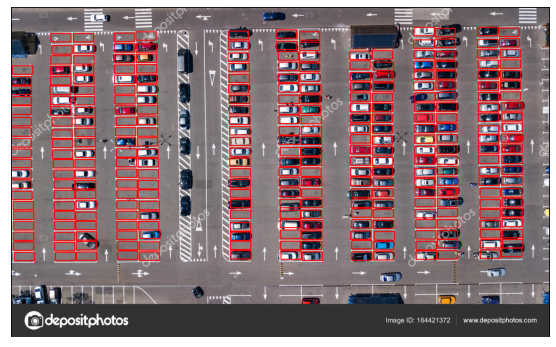

In [42]:
def assign_spots_map(image, spot_dict=my_spots, make_copy = True, color=[255, 0, 0], thickness=2):
    '''
    The function assigns slots to the parking area
    accordingly.

    Args:
        image: image
        spot_dict: dict,  Dictionary containing spots
        make_copy: bool
        color: Color of borders
        thickness: thickness of borders

    Returns:
        image showing designated parking slots
    '''

    if make_copy:
        new_image = np.copy(image)
    for spot in spot_dict.keys():
        (x1, y1, x2, y2) = spot
        cv2.rectangle(new_image, (int(x1),int(y1)), (int(x2),int(y2)), color, thickness)
    return new_image

marked_spot_images = list(map(assign_spots_map, test_images))
show_images(marked_spot_images)

In [43]:
### Save spot dictionary as pickle file
import pickle

with open(drive_path+'spot_dict.pickle', 'wb') as handle:
    pickle.dump(my_spots, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Use the model 

In [44]:
car_model = 'car_identifier.h5'

class_dictionary = {}
class_dictionary[0] = 'empty'
class_dictionary[1] = 'occupied'

In [45]:
model = load_model(car_model)

def make_prediction(image):
    '''
    This function makes predictions 
    with pre-loaded model

    Args:
        image: image
    Returns:
        labels
    '''
    #Rescale image
    img = image/255.

    image = np.expand_dims(img, axis=0)

    class_predicted = model.predict(image)
    inID = np.argmax(class_predicted[0])
    label = class_dictionary[inID]
    return label

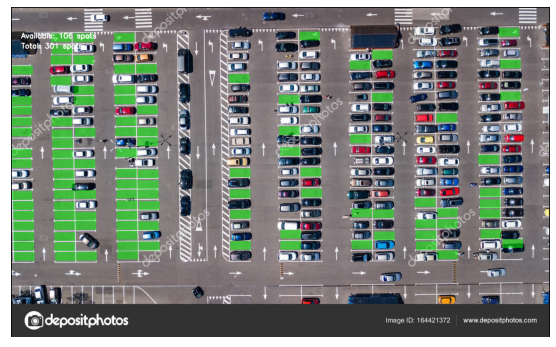

In [46]:
def predict_on_image(image, spot_dict = my_spots, make_copy=True, color = [0, 255, 0], alpha=0.5):
    '''
    This function places the predicted labels
    on the image
    Args:
        image: the image
        spot_dict: dict, containing the parking slots
        make_copy: bool
        color: color of highlighter
        alpha: opacity of highlighter
    Returns:
        returns image with the empty parking slots 
        highlighted
    '''
    if make_copy:
        new_image = np.copy(image)
        overlay = np.copy(image)
    cnt_empty = 0
    all_spots = 0
    for spot in spot_dict.keys():
        all_spots += 1
        (x1, y1, x2, y2) = spot
        (x1, y1, x2, y2) = (int(x1), int(y1), int(x2), int(y2))
        spot_img = image[y1:y2, x1:x2]
        spot_img = cv2.resize(spot_img, (48, 48)) 
        
        label = make_prediction(spot_img)
        if label == 'empty':
            cv2.rectangle(overlay, (int(x1),int(y1)), (int(x2),int(y2)), color, -1)
            cnt_empty += 1
            
    cv2.addWeighted(overlay, alpha, new_image, 1 - alpha, 0, new_image)
            
    cv2.putText(new_image, 'Available: %d spots' %cnt_empty, (30, 95),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.7, (255, 255, 255), 2)
    
    cv2.putText(new_image, 'Total: %d spots' %all_spots, (30, 125),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.7, (255, 255, 255), 2)
    save = False
    
    if save:
        filename = 'with_marking.jpg'
        cv2.imwrite(filename, new_image)
    
    return new_image


predicted_images = list(map(predict_on_image, test_images))
show_images(predicted_images)

Credits and Acknowledgements:
- https://medium.com/the-research-nest/parking-space-detection-using-deep-learning-9fc99a63875e
- https://github.com/Shobhit70/SmartParkingSystem/blob/master/test.jpg



### Thank you very much for your consideration

S M Ali Rizvi
- Porfolio: [Github Link](https://github.com/letdatado)
- LinkedIn: [LinkedIn's Profile](https://www.linkedin.com/in/smalir/)
- Contact: rizvey.ma@gmail.com